In [19]:
from bertopic import BERTopic
import pandas as pd
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
import matplotlib.pyplot as plt
import seaborn as sns
from utils import clean_traffic


In [20]:

def most_visited_topic_cluster(df,topics_count):
    topic_stats = df.groupby('topic')['traffic_numeric'].agg(['mean', 'median'])
    max = {"mean":0,"topic":None}
    r = range(0,topics_count)
    for i in r:
        element = topic_stats['mean'][i]
        comp = max["mean"]
        if element >= comp:
            max['mean'] = element
            max['topic'] = i
    return max

def max_element(List):
    list_max_element = 0
    for e in List:
        if e > list_max_element:
            list_max_element = e
    return list_max_element

In [21]:
# data = pd.read_csv("../preprocssed_data/cleaned_data_USA.csv")    
# data = pd.read_csv("../preprocssed_data/cleaned_data_UK.csv")    
# data = pd.read_csv("../preprocssed_data/cleaned_data_CANADA.csv")    
data = pd.read_csv("../preprocessed_data/cleaned_data_Belgium.csv")    

dataFrame = data[['newsTitle']]
strings_list = [item[0] for item in dataFrame.values.tolist()]


In [22]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(strings_list, show_progress_bar=True)

Batches: 100%|██████████| 76/76 [00:14<00:00,  5.39it/s]


In [23]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

In [24]:
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [25]:
vectorizer_model = CountVectorizer(stop_words="english")

In [26]:

keybert_model = KeyBERTInspired()

pos_model = PartOfSpeech("en_core_web_sm")

mmr_model = MaximalMarginalRelevance(diversity=0.3)

representation_model = {
    "KeyBERT": keybert_model,
    "MMR": mmr_model,
    "POS": pos_model
}

In [27]:
topic_model = BERTopic(
embedding_model=embedding_model,
umap_model=umap_model,
hdbscan_model=hdbscan_model,
vectorizer_model=vectorizer_model,
representation_model=representation_model,
top_n_words=10,
verbose=True
)

topics, probs = topic_model.fit_transform(strings_list)

names = topic_model.get_topic_info().Name
topic_model.get_topic_info()

2024-12-01 22:42:01,281 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 76/76 [00:14<00:00,  5.34it/s]
2024-12-01 22:42:15,575 - BERTopic - Embedding - Completed ✓
2024-12-01 22:42:15,576 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-01 22:42:24,928 - BERTopic - Dimensionality - Completed ✓
2024-12-01 22:42:24,930 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-01 22:42:25,061 - BERTopic - Cluster - Completed ✓
2024-12-01 22:42:25,066 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-01 22:42:26,992 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,KeyBERT,MMR,POS,Representative_Docs
0,-1,9,-1_lassalle_jean_candidat_normal,"[lassalle, jean, candidat, normal, soudan, fur...","[lassalle, candidat, candidature, candidats, l...","[lassalle, candidat, haynes, manifestants, léc...","[steunen, remplacer, potentiels, normal, manif...",[F1 Sebastian Vettel simpose au Grand Prix de...
1,0,1694,0_la_le_et_les,"[la, le, et, les, en, du, des, pour, sur, une]","[pas, une, contre, ligue, entre, pourquoi, dan...","[le, les, en, des, sur, une, est, 2017, pas, v...","[le, et, les, du, sur, est, dans, son, league,...",[Le chanteur Michel Polnareff est entre la vie...
2,1,661,1_van_op_voor_het,"[van, op, voor, het, en, met, ik, niet, een, z...","[het, zijn, nederlandse, antwerpen, vanavond, ...","[van, het, niet, zijn, dit, bij, brugge, club,...","[op, voor, niet, een, zijn, dit, naar, aan, ui...",[Dit moet u weten over de Ronde van Vlaanderen...
3,2,23,2_replay_revoir_lépisode_anges,"[replay, revoir, lépisode, anges, paradise, le...","[revoir, les, replay, lhorreur, anges, revenir...","[replay, revoir, paradise, les, princes, linvi...","[revoir, lépisode, du, mars, lémotion, janvier...",[REPLAY Les Anges 9 Back to Paradise revoir l...
4,3,14,3_federer_daustralie_open_nadal,"[federer, daustralie, open, nadal, hommes, rog...","[federer, djokovic, nadal, contre, tennis, nov...","[federer, daustralie, hommes, meespelen, novak...","[folles, statistiques, récital, retrouvera, ei...",[Open dAustralie Hommes Open dAustralie Nova...
5,4,13,4_anthony_caroline_borre_receveur,"[anthony, caroline, borre, receveur, 90000, se...","[vandenbussche, tournée, carrière, minérale, p...","[caroline, borre, receveur, minérale, carrière...","[sengagent, revendique, relation, philippin, d...",[Tournée Minérale plus de 90000 personnes seng...


In [28]:
df = pd.DataFrame({'topic':topics, 'probs':probs})
df['date'] = data[['date']]
df['traffic'] = data[['traffic']]
df['traffic_numeric'] = df['traffic'].apply(clean_traffic)
df


,topic,probs,date,traffic,traffic_numeric
0,0,1.000000,2016-11-29,"20,000+",20000
1,1,1.000000,2016-11-29,"2,000+",2000
2,1,1.000000,2016-11-29,"5,000+",5000
3,0,1.000000,2016-11-29,"2,000+",2000
4,0,1.000000,2016-11-29,"1,000+",1000
...,...,...,...,...,...
2409,0,1.000000,2017-05-04,"1,000+",1000
2410,0,0.953749,2017-05-04,"5,000+",5000
2411,1,1.000000,2017-05-04,"20,000+",20000
2412,0,1.000000,2017-05-04,"20,000+",20000


In [29]:
max = most_visited_topic_cluster(df,max_element(topics))
print(max)

{'mean': 7071.428571428572, 'topic': 3}


In [30]:
topic_model.get_topic(max['topic'])

[('federer', 0.5126245480173998),
 ('daustralie', 0.3562142979757643),
 ('open', 0.3042420364662044),
 ('nadal', 0.2589655472497078),
 ('hommes', 0.18254522187972264),
 ('roger', 0.135009395172488),
 ('lopen', 0.1294827736248539),
 ('goffin', 0.12169681458648175),
 ('en', 0.08977038175775785),
 ('léternité', 0.07806254872679902)]

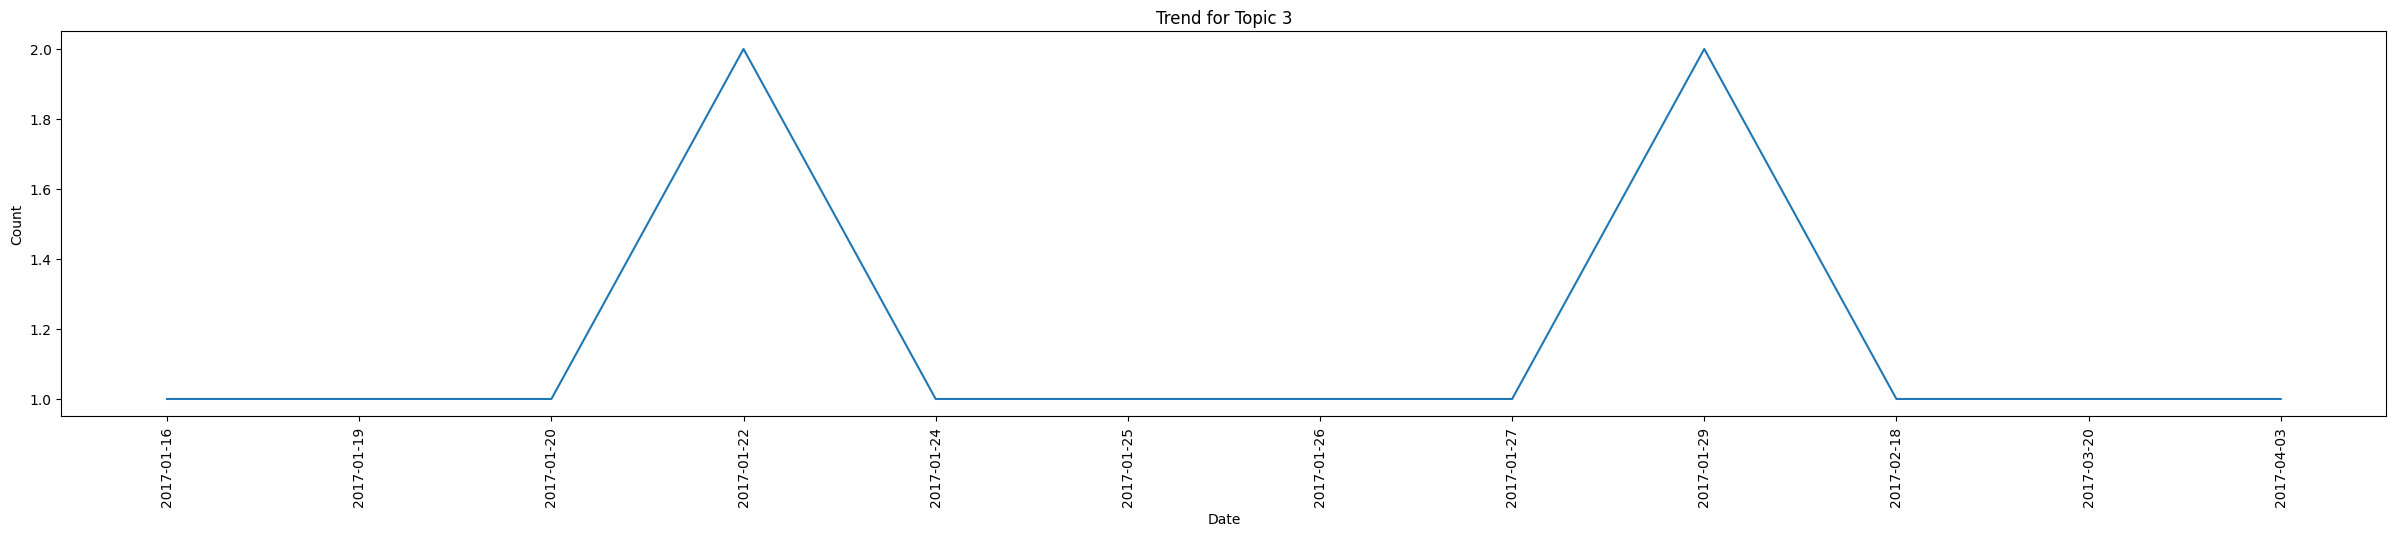

In [31]:
topic_time_distribution = df.groupby(['date', 'topic']).size().reset_index(name='count')
specific_topic = max['topic']
specific_topic_data = topic_time_distribution[topic_time_distribution['topic'] == specific_topic]
plt.figure(figsize=(30, 5))
sns.lineplot(data=specific_topic_data, x='date', y='count')
plt.title(f"Trend for Topic {specific_topic}")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()




In [32]:
names

0     -1_lassalle_jean_candidat_normal
1                       0_la_le_et_les
2                    1_van_op_voor_het
3       2_replay_revoir_lépisode_anges
4      3_federer_daustralie_open_nadal
5    4_anthony_caroline_borre_receveur
Name: Name, dtype: object

In [33]:
topic_model.visualize_topics()